# Linear regression using Tensor Flow 2.0

Reuse the same univariate polynomial model as in the [univariate linear regression workbook](LinearRegressionUnivariate.html)  ([Jupyter Notebook](LinearRegressionUnivariate.ipynb)) but with a TensorFlow implementation

From TensorFlow 2.0, recommended API is clearly the one of Keras. Building and fitting a model is performed in most cases with few lines of code. This is hidding a lot of the details on how the fit is done.

This tutorial is a mid step between the home made gradient descent of above mentionned tutorial and the fully wrapped Keras model as in [Bivariate linear regression with Keras](LinearRegressionBivariate-Keras.html) ([Notebook](LinearRegressionBivariate-Keras.ipynb))

The model is mostly hand designed, even if doing the same as the Keras Dense layer. But the optimizers are the powerful ones of Keras and TensorFlow.

Learning goals:
- Design a model in TensorFlow 2.0
- Use TensorFlow to perform gradient descents. 
- Compare several optimizers

References:
- https://databricks.com/tensorflow/training-and-convergence

In [1]:
import tensorflow as tf # TF 2.0 required
import numpy as np
import matplotlib.pyplot as plt
import pandas
from sklearn import metrics 

## Data model

In [2]:
# Univariate
def generateBatch(N, stochastic = False):
    #
    xMin = 0
    xMax = 0.5
    #
    b = 0.35
    std = 0.01
    #
    if stochastic:
        x = np.random.uniform(xMin, xMax, N)
    else:
        x = np.linspace(xMin, xMax, N)
    yClean = x**4 + (x-0.3)**3 + b
    y =  yClean + np.random.normal(0, std, N) 
    return (x, y, yClean)

## Reference values for linear regression

From [LinearRegressionUnivariate.ipynb](LinearRegressionUnivariate.ipynb)

In [3]:
wRef, bRef = 0.145, 0.323

### Test data

In [4]:
Ntest = 100000
(xTest, yTest1, yTestClean1) = generateBatch(Ntest)

### Shared parameters

In [5]:
# (Mini) Batch size
nBatch = 100
# Stop threshold on MSE
threshold = 1e-4
# Number of features in model
numFeatures = 1

## Helpers

In [6]:
# Plot helper to show target reference value
def plotToRef(label, subNum, subRow, subCol, ref, values):
    nIter = len(values)
    r = range(nIter)
    plt.subplot(subNum, subRow, subCol, alpha=1)
    plt.title(label)
    plt.plot(r, values, r, np.ones((nIter))*ref, alpha=0.5)
    plt.grid();

## Training model

From TensorFlow 2.0, the symbolic variables are no longer explicit, they look alike any Python variables.

The model is generated at "compile" time, rewritting and checking the code to act as a symbolic model

In [7]:
# Simple custom layer exposing the linear regression model
class MyDenseLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(MyDenseLayer, self).__init__(*args, **kwargs)
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=1.0,
            dtype=self.dtype,
            initializer=tf.keras.initializers.ones(),
            #regularizer=tf.keras.regularizers.l2(0.02),
            trainable=True)
        self.b = self.add_weight(
            shape=1.0,
            dtype=self.dtype,
            initializer=tf.keras.initializers.ones(),
            #regularizer=tf.keras.regularizers.l2(0.02),
            trainable=True)

    @tf.function
    def call(self, x, training=None):
        return x * self.w + self.b

## Gradient descent optimizer

In [8]:
# Model 1, instantiate the custom layer
model1 = tf.keras.Sequential([MyDenseLayer(input_shape=[numFeatures], dtype="float64")])

# Gradient Descent Optimizer
optim1 = tf.keras.optimizers.SGD(0.01)

# Perform a train step on a mini-batch
#  This function's code is rewritten by TensorFlow 2.0 and shall be compiled at every execution of the optimizer
@tf.function
def trainStep1(x, y):
    with tf.GradientTape() as tape:
        predictions = model1(x, training=True)
        loss = tf.keras.losses.mean_squared_error(y, predictions)
        
        gradients = tape.gradient(loss, model1.trainable_variables)
        optim1.apply_gradients(zip(gradients, model1.trainable_variables))
        return loss
    
# Initialize values
mse = 1
wLearn = []
while mse > threshold:
#nEpoch = 1000
#for epoch in range(1, nEpoch+1):
    (xTrain, yTrain, yTrainClean) = generateBatch(nBatch, True)
    
    mse = trainStep1(xTrain, yTrain)
    currentW = model1.get_weights()
    w = currentW[0][0]
    b = currentW[1][0]
    wLearn.append((b, w, mse))
        
print("Predicted model: {a:.3f} x + {b:.3f}, num iterations={c}".format(a=w, b=b, c=len(wLearn)))
df1 = pandas.DataFrame(wLearn, columns = ('b', 'w', 'MSE'))

Predicted model: 0.171 x + 0.316, num iterations=8140


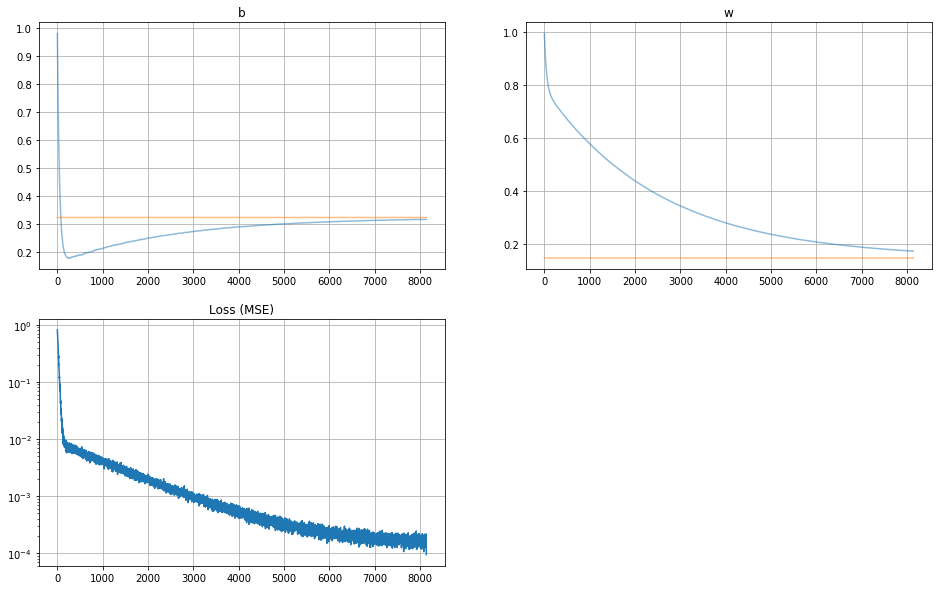

In [9]:
fig = plt.figure(figsize=(16,10))
plotToRef('b', 2, 2, 1, bRef, df1['b'])
plotToRef('w', 2, 2, 2, wRef, df1['w'])
plt.subplot(2,2,3)
plt.semilogy(df1['MSE'])
plt.grid()
plt.title(('Loss (MSE)'));

### Test model 

In [10]:
yEst1 = w * xTest + b

Gradient Optimizer MSE = 1.641e-04


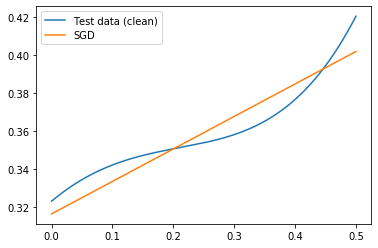

In [11]:
plt.plot(xTest, yTestClean1, xTest, yEst1);
plt.legend(('Test data (clean)', 'SGD'), loc='upper left')
mse1 = metrics.mean_squared_error(yTest1, yEst1)
print('Gradient Optimizer MSE = {:.3e}'.format(mse1));

## Moment optimizer

In [12]:
# Model, instantiate the custom layer
model2 = tf.keras.Sequential([MyDenseLayer(input_shape=[numFeatures], dtype="float64")])

# Gradient Descent Optimizer
optim2 = tf.keras.optimizers.SGD(0.01, momentum=0.0001) # <---

# Perform a train step on a mini-batch
#  This function's code is rewritten by TensorFlow 2.0 and shall be compiled at every execution of the optimizer
@tf.function
def trainStep2(x, y):
    with tf.GradientTape() as tape:
        predictions = model2(x, training=True)
        loss = tf.keras.losses.mean_squared_error(y, predictions)
        
        gradients = tape.gradient(loss, model2.trainable_variables)
        optim2.apply_gradients(zip(gradients, model2.trainable_variables))
        return loss
    
# Initialize values
mse = 1
wLearn = []
while mse > threshold:
    (xTrain, yTrain, yTrainClean) = generateBatch(nBatch, True)
    
    mse = trainStep2(xTrain, yTrain)
    currentW = model2.get_weights()
    w = currentW[0][0]
    b = currentW[1][0]
    wLearn.append((b, w, mse))
        
print("Predicted model: {a:.3f} x + {b:.3f}, num iterations={c}".format(a=w, b=b, c=len(wLearn)))
df2 = pandas.DataFrame(wLearn, columns = ('b', 'w', 'MSE'))

Predicted model: 0.177 x + 0.315, num iterations=7644


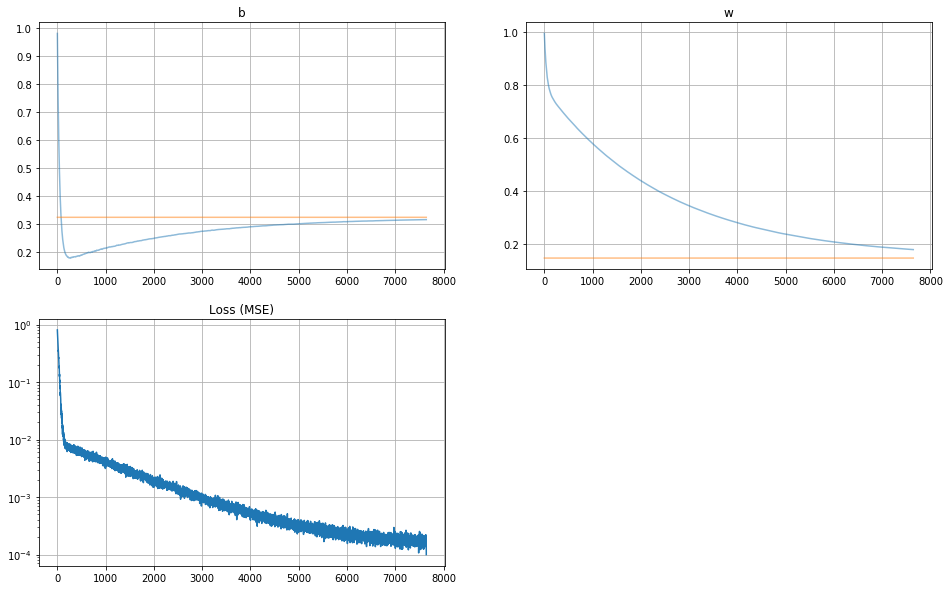

In [13]:
fig = plt.figure(figsize=(16,10))
plotToRef('b', 2, 2, 1, bRef, df2['b'])
plotToRef('w', 2, 2, 2, wRef, df2['w'])
plt.subplot(2,2,3)
plt.semilogy(df2['MSE'])
plt.grid()
plt.title(('Loss (MSE)'));

In [14]:
yEst2 = w * xTest + b

Moment Optimizer MSE = 1.712e-04


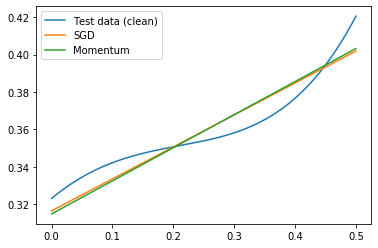

In [15]:
plt.plot(xTest, yTestClean1, xTest, yEst1, xTest, yEst2);
plt.legend(('Test data (clean)', 'SGD', 'Momentum'), loc='upper left')
mse2 = metrics.mean_squared_error(yTest1, yEst2)
print('Moment Optimizer MSE = {:.3e}'.format(mse2));

### Adam optimizer

https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer

http://arxiv.org/pdf/1412.6980.pdf

In [16]:
# Model, instantiate the custom layer
model3 = tf.keras.Sequential([MyDenseLayer(input_shape=[numFeatures], dtype="float64")])

# Gradient Descent Optimizer
optim3 = tf.keras.optimizers.Adam(0.01) # <---

# Perform a train step on a mini-batch
#  This function's code is rewritten by TensorFlow 2.0 and shall be compiled at every execution of the optimizer
@tf.function
def trainStep3(x, y):
    with tf.GradientTape() as tape:
        predictions = model3(x, training=True)
        loss = tf.keras.losses.mean_squared_error(y, predictions)
        
        gradients = tape.gradient(loss, model3.trainable_variables)
        optim3.apply_gradients(zip(gradients, model3.trainable_variables))
        return loss
    
# Initialize values
mse = 1
wLearn = []
while mse > threshold:
    (xTrain, yTrain, yTrainClean) = generateBatch(nBatch, True)
    
    mse = trainStep3(xTrain, yTrain)
    currentW = model3.get_weights()
    w = currentW[0][0]
    b = currentW[1][0]
    wLearn.append((b, w, mse))
        
print("Predicted model: {a:.3f} x + {b:.3f}, num iterations={c}".format(a=w, b=b, c=len(wLearn)))
df3 = pandas.DataFrame(wLearn, columns = ('b', 'w', 'MSE'))

Predicted model: 0.148 x + 0.322, num iterations=1110


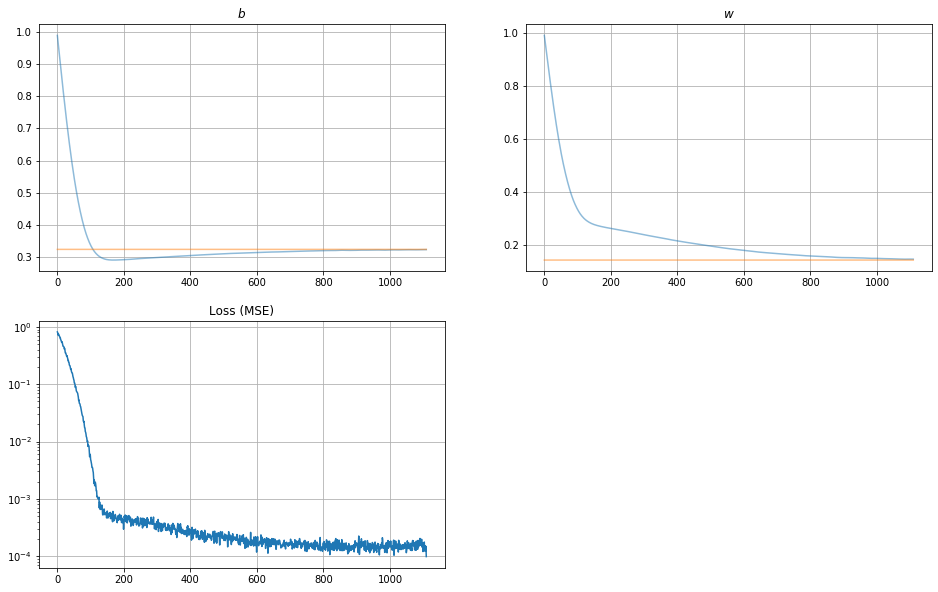

In [20]:
fig = plt.figure(figsize=(16,10))
plotToRef('$b$', 2, 2, 1, bRef, df3['b'])
plotToRef('$w$', 2, 2, 2, wRef, df3['w'])
plt.subplot(2,2,3)
plt.semilogy(df3['MSE'])
plt.grid()
plt.title(('Loss (MSE)'));

There is a clear gain compared to the standard and momentum gradient descent : 
- Less iterations
- Less undershoot on $b$
- Clear convergence of the MSE to the noise floor


In [18]:
yEst3 = w * xTest + b

Adam Optimizer MSE = 1.497e-04


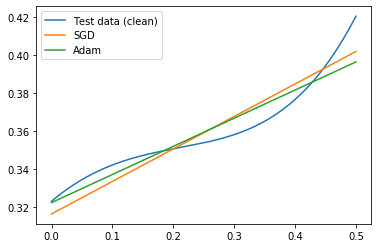

In [19]:
plt.plot(xTest, yTestClean1, xTest, yEst1, xTest, yEst3);
plt.legend(('Test data (clean)', 'SGD', 'Adam'), loc='upper left')
mse3 = metrics.mean_squared_error(yTest1, yEst3)
print('Adam Optimizer MSE = {:.3e}'.format(mse3));

# Where to go from here ?

__Other single feature linear implementation__ [using closed form, Scipy, SKLearn or "raw" Python](LinearRegressionUnivariate.html) ([Notebook](LinearRegressionUnivariate.ipynb))

__More complex bivariation models__ [using "raw" Python](LinearRegressionBivariate.html) ([Notebook](LinearRegressionBivariate.ipynb)) up to the gradient descent with regularizer, or [using Keras](LinearRegressionBivariate-Keras.html) ([Notebook](LinearRegressionBivariate-Keras.ipynb))

__Compare with the single feature binary classification using logistic regression__ [using "raw" Python or libraries](../classification/ClassificationContinuousSingleFeature.html) ([Notebook](../classification/ClassificationContinuousSingleFeature.ipynb]))